In [2]:
import pandas as pd
import numpy as np
import json
import re
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [3]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)

destination_dir = '../data/raw/'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(destination_dir, filename))

print("Files moved to:", destination_dir)

Path to dataset files: /home/vnbl/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1
Files moved to: ../data/raw/


# 1. Data Exploration/Preparation

In [4]:
spotify_df = pd.read_csv(destination_dir + 'dataset.csv')

In [5]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [6]:
spotify_df.dtypes

Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

# 1.1 Analyzing object data types
* track_id: Should be unique
* artists: Should be a list of strings
* album_name: Should be string (later on, categorical?)
* track_name: Should be string 
* track_genre: Should be string (categorical)

In [7]:
df = spotify_df.copy()
# track id
is_unique = df['track_id'].is_unique

if is_unique:
    print("Track ID is unique")
else:
    print("Track ID is not unique")

duplicates = df[df['track_id'].duplicated()]
if not duplicates.empty:
    print("Duplicate track IDs:")
    print(duplicates.info())

Track ID is not unique
Duplicate track IDs:
<class 'pandas.core.frame.DataFrame'>
Index: 24259 entries, 1925 to 113641
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        24259 non-null  int64  
 1   track_id          24259 non-null  object 
 2   artists           24259 non-null  object 
 3   album_name        24259 non-null  object 
 4   track_name        24259 non-null  object 
 5   popularity        24259 non-null  int64  
 6   duration_ms       24259 non-null  int64  
 7   explicit          24259 non-null  bool   
 8   danceability      24259 non-null  float64
 9   energy            24259 non-null  float64
 10  key               24259 non-null  int64  
 11  loudness          24259 non-null  float64
 12  mode              24259 non-null  int64  
 13  speechiness       24259 non-null  float64
 14  acousticness      24259 non-null  float64
 15  instrumentalness  24259 non-null  float64
 1

In [ ]:
# Check how many duplicates exist for each track_id
track_id_counts = df['track_id'].value_counts()

# Show track_ids with more than one occurrence
duplicates_with_counts = track_id_counts[track_id_counts > 1]
print(duplicates_with_counts)

# Check if any of the rows with duplicated track_ids are identical across all columns
duplicate_rows = df[df['track_id'].isin(duplicates_with_counts.index)]
duplicate_rows_unique_check = duplicate_rows.drop_duplicates()

print(f"Number of duplicate rows: {len(duplicate_rows)}")
print(f"Number of unique duplicate rows: {len(duplicate_rows_unique_check)}")

if len(duplicate_rows) != len(duplicate_rows_unique_check):
    print("Some rows with the same track_id have different information.")
else:
    print("All rows with the same track_id are identical.")


track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
4WJTKbNJQ41zXnb84jSWaj    7
2aaClnypAakdAmLw74JXxB    7
                         ..
4YUWeLwUwRMzuxW5H4ASYp    2
4OtqlH4UCGzV8fLy36STjE    2
5pZEThCuY84PiajfmeOJ3i    2
06yiYlbdcanbh4GJEFyhEj    2
32J2hO5MU8pmA1l9UbIV0u    2
Name: count, Length: 16641, dtype: int64
Number of duplicate rows: 40900
Number of unique duplicate rows: 40900
All rows with the same track_id are identical.


In [9]:
df = df.drop_duplicates(subset='track_id', keep='first')
print(spotify_df.shape)
df.shape

(114000, 21)


(89741, 21)

In [10]:
# artists
df['artists'] = df['artists'].fillna('')

df['artists_v1'] = df['artists'].str.replace(';', ',', regex=False).str.split(',')
df['artists_v1'] = df['artists_v1'].apply(lambda x: [artist.strip() for artist in x if isinstance(artist, str)] if isinstance(x, list) else [])
df['artists_v1'].info()

<class 'pandas.core.series.Series'>
Index: 89741 entries, 0 to 113999
Series name: artists_v1
Non-Null Count  Dtype 
--------------  ----- 
89741 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


In [11]:
# album name

missing_album_name = df['album_name'].isnull().sum()
print(f"Number of missing album names: {missing_album_name}")

missing_album_name_rows = df[df['album_name'].isnull()]
print(missing_album_name_rows)

df = df.dropna(subset=['album_name'])


Number of missing album names: 1
       Unnamed: 0                track_id artists album_name track_name  \
65900       65900  1kR4gIb7nGxHPI3D2ifs59                NaN        NaN   

       popularity  duration_ms  explicit  danceability  energy  ...  mode  \
65900           0            0     False         0.501   0.583  ...     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
65900       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature  track_genre  artists_v1  
65900  138.391               4        k-pop          []  

[1 rows x 22 columns]


# 2. Feature Engineering
* Normalize float variables
* One hot encoding popularity variables
* Create TF-IDF features off of artist genres

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89740 entries, 0 to 113999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        89740 non-null  int64  
 1   track_id          89740 non-null  object 
 2   artists           89740 non-null  object 
 3   album_name        89740 non-null  object 
 4   track_name        89740 non-null  object 
 5   popularity        89740 non-null  int64  
 6   duration_ms       89740 non-null  int64  
 7   explicit          89740 non-null  bool   
 8   danceability      89740 non-null  float64
 9   energy            89740 non-null  float64
 10  key               89740 non-null  int64  
 11  loudness          89740 non-null  float64
 12  mode              89740 non-null  int64  
 13  speechiness       89740 non-null  float64
 14  acousticness      89740 non-null  float64
 15  instrumentalness  89740 non-null  float64
 16  liveness          89740 non-null  float64
 1

In [13]:
float_cols = df.dtypes[df.dtypes == 'float64'].index.values
print("float columns:")
print(float_cols)

mhe_columns = ['artists']

category_columns = ['album_name']

ohe_columns = ['explicit', 'mode', 'key', 'speechiness', 'time_signature', 'track_genre']

normalize_columns = ['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity']

speechiness_bins = {'speech_only' : [0.66, 1.0], 'music_and_speech' : [0.33, 0.66], 'music_only' : [0.0, 0.33]}

float columns:
['danceability' 'energy' 'loudness' 'speechiness' 'acousticness'
 'instrumentalness' 'liveness' 'valence' 'tempo']


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np

# Create a copy of the original DataFrame
df_features = df.copy()

# multi-hot encoding for artists
df_features['artists'] = df_features['artists'].str.replace(';', ',', regex=False).str.split(',')
df_features['artists'] = df_features['artists'].apply(lambda x: [artist.strip() for artist in x if pd.notnull(artist)])
df_features['artists'] = df_features['artists'].apply(lambda x: ' '.join(x))  # Join as a single string for TF-IDF

# bins for speechiness
speechiness_bins = {'speech_only': [0.66, 1.0], 'music_and_speech': [0.33, 0.66], 'music_only': [0.0, 0.33]}
def categorize_speechiness(value):
    for category, (lower, upper) in speechiness_bins.items():
        if lower <= value <= upper:
            return category
    return np.nan

df_features['speechiness_bin'] = df_features['speechiness'].apply(categorize_speechiness)

# one-hot encoding for categorical, boolean, and speechiness bin columns
ohe_columns = ['explicit', 'mode', 'key', 'time_signature', 'speechiness_bin']
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')

# Apply OHE and convert to DataFrame
ohe_df = pd.DataFrame(ohe_encoder.fit_transform(df_features[ohe_columns]), columns=ohe_encoder.get_feature_names_out(ohe_columns))
df_features = pd.concat([df_features, ohe_df], axis=1).drop(columns=ohe_columns)

# TF-IDF encoding with truncatedSVD for dimensionality reduction
tfidf_columns = ['track_genre']
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size to 5000

for col in tfidf_columns:
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_features[col].fillna(''))
    # Dimensionality reduction to 100 components
    svd = TruncatedSVD(n_components=100, random_state=42)
    tfidf_reduced = svd.fit_transform(tfidf_matrix)
    tfidf_df = pd.DataFrame(tfidf_reduced, columns=[f'{col}_svd_{i}' for i in range(100)])
    df_features = pd.concat([df_features, tfidf_df], axis=1).drop(columns=[col])

# Normalize numerical columns
normalize_columns = ['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity']
scaler = MinMaxScaler()

df_features[normalize_columns] = scaler.fit_transform(df_features[normalize_columns])

# Final processed DataFrame
df_features.head()



Unnamed: 0                track_id                 artists  \
0         0.0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1         1.0  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2         2.0  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson ZAYN   
3         3.0  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4         4.0  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  danceability  energy  \
0                      Comedy        0.73     0.042473      0.686294  0.4610   
1            Ghost - Acoustic        0.55     0.026971      0.426396  0.1660   
2              To Begin Again        0.57     0.038679      0.444670  0.3590   
3  Can't Help Falling In Love        0.71     0.036978      0.270051  0.0596   
4                     Hold On        0.82     0.036389      0.627411  0.4430   

   loudness  ...  track_genre_svd_90  track_genre_svd_91  track_genre_svd_92  \
0  0.791392  ...        1.377011e-15       -1.079676e-15        1.542481e-16   
1  0.597377  ...        1.377011e-15       -1.079676e-15        1.542481e-16   
2  0.736123  ...        1.377011e-15       -1.079676e-15        1.542481e-16   
3  0.573701  ...        1.377011e-15       -1.079676e-15        1.542481e-16   
4  0.737103  ...        1.377011e-15       -1.079676e-15        1.542481e-16   

   track_genre_svd_93  track_genre_svd_94  track_genre_svd_95  \
0        2.942674e-15       -3.407491e-16       -6.310463e-16   
1        2.942674e-15       -3.407491e-16       -6.310463e-16   
2        2.942674e-15       -3.407491e-16       -6.310463e-16   
3        2.942674e-15       -3.407491e-16       -6.310463e-16   
4        2.942674e-15       -3.407491e-16       -6.310463e-16   

  track_genre_svd_96  track_genre_svd_97  track_genre_svd_98  \
0       4.688874e-16       -5.448738e-16        1.214842e-15   
1       4.688874e-16       -5.448738e-16        1.214842e-15   
2       4.688874e-16       -5.448738e-16        1.214842e-15   
3       4.688874e-16       -5.448738e-16        1.214842e-15   
4       4.688874e-16       -5.448738e-16        1.214842e-15   

   track_genre_svd_99  
0        3.333551e-18  
1        3.333551e-18  
2        3.333551e-18  
3        3.333551e-18  
4        3.333551e-18  

[5 rows x 136 columns]

# SPOTIFY

In [15]:
# import client_id and client_secret from .env file
import os
from dotenv import load_dotenv

load_dotenv()

client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")


In [16]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: {} username".format(sys.argv[0]))
    sys.exit()

In [17]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [18]:
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri='http://localhost:8888/callback')

Using 'localhost' as a redirect URI is being deprecated. Use a loopback IP address such as 127.0.0.1 to ensure your app remains functional.
2025/03/13 01:25:24.355893 cmd_run.go:1285: WARNING: cannot start document portal: dial unix /run/user/1000/bus: connect: no such file or directory
[120111, Main Thread] WARNING: Settings portal not found: Could not connect: No such file or directory: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:120111): Gdk-WARNING **: 01:25:26.583: Settings portal not found: Could not connect: No such file or directory
[Parent 120111, Main Thread] WARNING: Failed to mkdir /home/vnbl/snap/firefox/5836/.config/ibus/bus: Not a directory: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:120111): IBUS-WARNING **: 01:25:27.587: Failed to mkdir /home/vnbl/snap/firefox/5836/.config/ibus/bus: Not a directory
[Parent 120111, Main Thread] WARNING: Failed

In [19]:
sp = spotipy.Spotify(auth=token)

In [20]:
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [21]:
id_name

{'Asunción': '4XtxsmsZVZgAoMn44AEm2t',
 'Bruxa Amarelha ✨': '3N0MRsfxLUJbdglpL87RJ1',
 'Domingo': '22GUL8gcEZdDJCCFG3pYKB',
 'Nobody Likes Techno': '15ZCfrqmrtn4Qdx6gq5PRY',
 'Para Joaquín': '0Bw6c1LUDyRAV9J3rhu25J',
 'Piseiro purete': '291fVO9IZJLfUXnxne69dZ',
 'Wicked lazy💥': '5WfqjOuXP5da6caIgvQSjC',
 'Mais devagar': '5SU5hzHDMHmHhJf4xWaPaB',
 'Modo turbo': '6DCLM0mbFH7jfvRPBJk5Oq',
 'Robotica 3y4': '0xmIkvqte8IE5uEKTTCdpF',
 'Jueves de Retrotón': '0S89QV5Mh7vpbiakXH6Jg0',
 'Nutritivo': '0IWum7rcFJLlk42Qqz4O7x',
 'jipi jopi': '2moPoR37Q5UQd053qkpZ85',
 'Yendo al súper': '0J8Z7hxdZoSZmKyTtUCKzX',
 'Canciones pa Fer': '2PGvuhIpVpNxJHuaqEwgua',
 'Sugar water': '6SCPmXPVCRPGsP3HmVWHg5',
 "Give'em whiplash": '2hLIDDQWYBLNYwHtieY22n',
 'sunny disposition': '36hqDUwKXvcZsVeeXtfu5W',
 'Prog Magic': '4xV5ywhJzJJFtUZ4E9Ha4B',
 'Metal': '6hDunw3xx5U4tqpfkosNQs',
 'Art District': '60imScM1oHEm18bAACrnfv',
 'Bien sûr': '76zASv5c9TmmHjzyW7ScX9',
 'Cartoon Tunes 💕': '5VQZ6kZ39AphoqoeW8sS3X',
 'Afr

In [22]:
def create_necessary_outputs(playlist_name, id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify dataframe
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    # Generate playlist dataframe
    playlist = pd.DataFrame()
    try:
        for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
            playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
            playlist.loc[ix, 'name'] = i['track']['name']
            playlist.loc[ix, 'id'] = i['track']['id']  # ['uri'].split(':')[2]
            playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
            playlist.loc[ix, 'date_added'] = i['added_at']
        
        # Convert date_added to datetime
        playlist['date_added'] = pd.to_datetime(playlist['date_added'])
        
        # Filter to only include tracks available in the dataset
        playlist = playlist[playlist['id'].isin(df['track_id'].values)].sort_values('date_added', ascending=False)
        
        return playlist
    
    except Exception as e:
        print(f"Error processing playlist {playlist_name}: {e}")
        return None  # Return None if there's an error with this playlist

def create_necessary_outputs_all_playlists(id_dic, df):
    """ 
    Pull songs from all playlists.

    Parameters: 
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify dataframe
        
    Returns: 
        all_playlists: concatenated DataFrame of all songs from the playlists that are available in the dataset
    """
    
    all_playlists = []
    
    # Iterate over each playlist
    for playlist_name, playlist_id in id_dic.items():
        playlist_data = create_necessary_outputs(playlist_name, id_dic, df)
        
        # Skip if the output is None (error occurred in creating the playlist)
        if playlist_data is not None:
            all_playlists.append(playlist_data)
    
    # Concatenate all valid playlists into a single DataFrame
    if all_playlists:
        all_playlists_combined = pd.concat(all_playlists, ignore_index=True)
        return all_playlists_combined
    else:
        return None  # Return None if no valid playlists were found

# Example usage
all_playlists = create_necessary_outputs_all_playlists(id_name, df)


Error processing playlist Robotica 3y4: 'NoneType' object is not subscriptable


In [37]:
playlist_wicked = create_necessary_outputs('Metal', id_name, df_features)
playlist_wicked.info()
#print(df_features.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 3 to 1
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   artist      2 non-null      object             
 1   name        2 non-null      object             
 2   id          2 non-null      object             
 3   url         2 non-null      object             
 4   date_added  2 non-null      datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 96.0+ bytes


In [24]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

artist   name                      id  \
9  Doja Cat  Woman  6Uj1ctrBOjOas8xZXGqKk4   

                                                 url                date_added  
9  https://i.scdn.co/image/ab67616d00001e02be841b... 2021-09-08 10:55:56+00:00

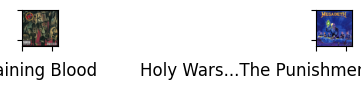

In [96]:
visualize_songs(playlist_wicked)

In [38]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    # Ensure the playlist_df has the correct column names for merging
    if 'id' not in playlist_df.columns:
        playlist_df.rename(columns={'track_id': 'id'}, inplace=True)
    
    # Merge the complete feature set with the playlist dataframe based on 'track_id' and 'id'
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['track_id'].isin(playlist_df['id'].values)]
    
    # Merge on 'track_id' in complete_feature_set and 'id' in playlist_df
    complete_feature_set_playlist = complete_feature_set_playlist.merge(
        playlist_df[['id', 'date_added']], 
        left_on='track_id', 
        right_on='id', 
        how='inner'
    )

    # Separate out non-playlist songs from the complete feature set
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['track_id'].isin(playlist_df['id'].values)]
    
    # Sort playlist songs by recency (most recent first)
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added', ascending=False)

    # Get the most recent date from the playlist
    most_recent_date = playlist_feature_set.iloc[0]['date_added']
    
    # Calculate the number of months since the most recent date for each song (vectorized)
    playlist_feature_set['months_from_recent'] = ((most_recent_date - playlist_feature_set['date_added']).dt.days / 30).astype(int)

    # Calculate weight based on recency (weight_factor ^ -months_from_recent)
    playlist_feature_set['weight'] = weight_factor ** (-playlist_feature_set['months_from_recent'])
    
    # Define the feature columns (exclude 'id', 'date_added', 'months_from_recent', 'weight')
    feature_columns = [col for col in playlist_feature_set.columns if col not in ['id', 'date_added', 'months_from_recent', 'weight'] and pd.api.types.is_numeric_dtype(playlist_feature_set[col])]
    
    # Debug: Check the data types of the feature columns
    print(playlist_feature_set[feature_columns].dtypes)
    
    # Ensure weights are numeric
    playlist_feature_set['weight'] = playlist_feature_set['weight'].astype(float)
    
    # Apply weights to the feature columns (exclude 'id', 'date_added', 'months_from_recent', 'weight')
    playlist_feature_set_weighted = playlist_feature_set.copy()
    playlist_feature_set_weighted[feature_columns] = playlist_feature_set[feature_columns].mul(playlist_feature_set['weight'], axis=0)

    # Sum the weighted features to create a single feature vector for the playlist
    playlist_feature_set_weighted_final = playlist_feature_set_weighted[feature_columns].sum(axis=0)
    
    return playlist_feature_set_weighted_final, complete_feature_set_nonplaylist


In [39]:
complete_feature_set_playlist_vector_wicked, complete_feature_set_nonplaylist_wicked = generate_playlist_feature(df_features, playlist_wicked, 1.09)

Unnamed: 0            float64
popularity            float64
duration_ms           float64
danceability          float64
energy                float64
                       ...   
track_genre_svd_95    float64
track_genre_svd_96    float64
track_genre_svd_97    float64
track_genre_svd_98    float64
track_genre_svd_99    float64
Length: 131, dtype: object


In [40]:
print(complete_feature_set_playlist_vector_wicked)

Unnamed: 0            6.933400e+04
popularity            1.340000e+00
duration_ms           1.206061e-01
danceability          5.604061e-01
energy                1.980000e+00
                          ...     
track_genre_svd_95    5.940697e-15
track_genre_svd_96    2.610517e-15
track_genre_svd_97   -5.822418e-15
track_genre_svd_98    8.397790e-15
track_genre_svd_99    2.493163e-16
Length: 131, dtype: float64


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    # Ensure only numeric columns are used for similarity calculation
    nonplaylist_features_numeric = nonplaylist_features.select_dtypes(include=['float64', 'int64'])
    print("Non-playlist numeric features shape:", nonplaylist_features_numeric.shape)  # Debugging
    
    # List the column names of non-playlist features for debugging
    print("Non-playlist numeric feature columns:", nonplaylist_features_numeric.columns.tolist())
    
    # Handle missing values by filling NaNs with the column mean
    nonplaylist_features_numeric = nonplaylist_features_numeric.fillna(nonplaylist_features_numeric.mean())
    
    # Filter non-playlist dataframe based on track_id match
    non_playlist_df = df[df['track_id'].isin(nonplaylist_features['track_id'].values)]
    print(f"After filtering, non_playlist_df has {non_playlist_df.shape[0]} rows.")  # Debugging
    
    # List the columns of df to verify track_id and others
    print("Columns in non_playlist_df:", non_playlist_df.columns.tolist())
    
    # Ensure the features are also numeric and handle NaNs
    features_numeric = features[nonplaylist_features_numeric.columns].fillna(nonplaylist_features_numeric.mean())
    
    # Reshape the feature vector of the playlist
    features_numeric_reshaped = features_numeric.values.reshape(1, -1)
    
    # Calculate the cosine similarity
    sim_values = cosine_similarity(nonplaylist_features_numeric.values, features_numeric_reshaped).flatten()  # Flatten the result to 1D array
    print(f"Cosine similarity values shape: {sim_values.shape}")  # Debugging
    
    # Add similarity values to the dataframe
    non_playlist_df['sim'] = sim_values
    
    # Sort the songs by similarity and get the top 40
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim', ascending=False).head(40)  # Changed to 40 instead of 10
    print(f"Top 40 songs after sorting: {non_playlist_df_top_40.shape[0]} rows.")  # Debugging
    
    # Check the track_id column for NaN values in the top 40
    print("Track IDs in top 40 before filtering:", non_playlist_df_top_40['track_id'].isna().sum())  # Debugging
    
    # List the track_ids in top 40 for debugging
    print("Track IDs in top 40:", non_playlist_df_top_40['track_id'].head())  # Check the first few track_ids
    
    # Filter out rows with NaN track_id
    non_playlist_df_top_40 = non_playlist_df_top_40[non_playlist_df_top_40['track_id'].notna()]
    print(f"After removing NaN track_ids, we have {non_playlist_df_top_40.shape[0]} rows.")  # Debugging
    
    # If no valid track_id left, show the names of the columns for further inspection
    if non_playlist_df_top_40.shape[0] == 0:
        print("No valid track_id entries found. Inspecting columns in the dataframe:")
        print(non_playlist_df_top_40.columns.tolist())
    
    # If track_id is not a valid base62 ID, you can also handle that here by filtering invalid IDs
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['track_id'].apply(lambda x: get_spotify_url(x))
    
    return non_playlist_df_top_40

def get_spotify_url(track_id):
    """ Helper function to get the track URL from Spotify API. """
    try:
        # Call the Spotify API to get track info
        if track_id and isinstance(track_id, str):  # Ensure track_id is valid
            return sp.track(track_id)['album']['images'][1]['url']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving track {track_id}: {e}")
        return None

# Example usage
wicked_top_40 = generate_playlist_recos(df_features, complete_feature_set_playlist_vector_wicked, complete_feature_set_nonplaylist_wicked)


Non-playlist numeric features shape: (112794, 131)
Non-playlist numeric feature columns: ['Unnamed: 0', 'popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'explicit_True', 'mode_1', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'speechiness_bin_music_only', 'speechiness_bin_speech_only', 'track_genre_svd_0', 'track_genre_svd_1', 'track_genre_svd_2', 'track_genre_svd_3', 'track_genre_svd_4', 'track_genre_svd_5', 'track_genre_svd_6', 'track_genre_svd_7', 'track_genre_svd_8', 'track_genre_svd_9', 'track_genre_svd_10', 'track_genre_svd_11', 'track_genre_svd_12', 'track_genre_svd_13', 'track_genre_svd_14', 'track_genre_svd_15', 'track_genre_svd_16', 'track_genre_svd_17', 'track_genre_svd_18', 'track_genre_svd_19', 'track_genre_svd_20', 'track_genre_svd_21', 'tr

In [31]:
wicked_top_40

Empty DataFrame
Columns: [Unnamed: 0, track_id, artists, album_name, track_name, popularity, duration_ms, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, artists_v1, explicit_True, mode_1, key_1, key_2, key_3, key_4, key_5, key_6, key_7, key_8, key_9, key_10, key_11, time_signature_1, time_signature_3, time_signature_4, time_signature_5, speechiness_bin_music_only, speechiness_bin_speech_only, track_genre_svd_0, track_genre_svd_1, track_genre_svd_2, track_genre_svd_3, track_genre_svd_4, track_genre_svd_5, track_genre_svd_6, track_genre_svd_7, track_genre_svd_8, track_genre_svd_9, track_genre_svd_10, track_genre_svd_11, track_genre_svd_12, track_genre_svd_13, track_genre_svd_14, track_genre_svd_15, track_genre_svd_16, track_genre_svd_17, track_genre_svd_18, track_genre_svd_19, track_genre_svd_20, track_genre_svd_21, track_genre_svd_22, track_genre_svd_23, track_genre_svd_24, track_genre_svd_25, track_genre_svd_26, track_genre_svd_27, track_genre_svd_28, track_genre_svd_29, track_genre_svd_30, track_genre_svd_31, track_genre_svd_32, track_genre_svd_33, track_genre_svd_34, track_genre_svd_35, track_genre_svd_36, track_genre_svd_37, track_genre_svd_38, track_genre_svd_39, track_genre_svd_40, track_genre_svd_41, track_genre_svd_42, track_genre_svd_43, track_genre_svd_44, track_genre_svd_45, track_genre_svd_46, track_genre_svd_47, track_genre_svd_48, track_genre_svd_49, track_genre_svd_50, track_genre_svd_51, track_genre_svd_52, track_genre_svd_53, track_genre_svd_54, track_genre_svd_55, track_genre_svd_56, track_genre_svd_57, track_genre_svd_58, track_genre_svd_59, track_genre_svd_60, track_genre_svd_61, track_genre_svd_62, track_genre_svd_63, ...]
Index: []

[0 rows x 138 columns]

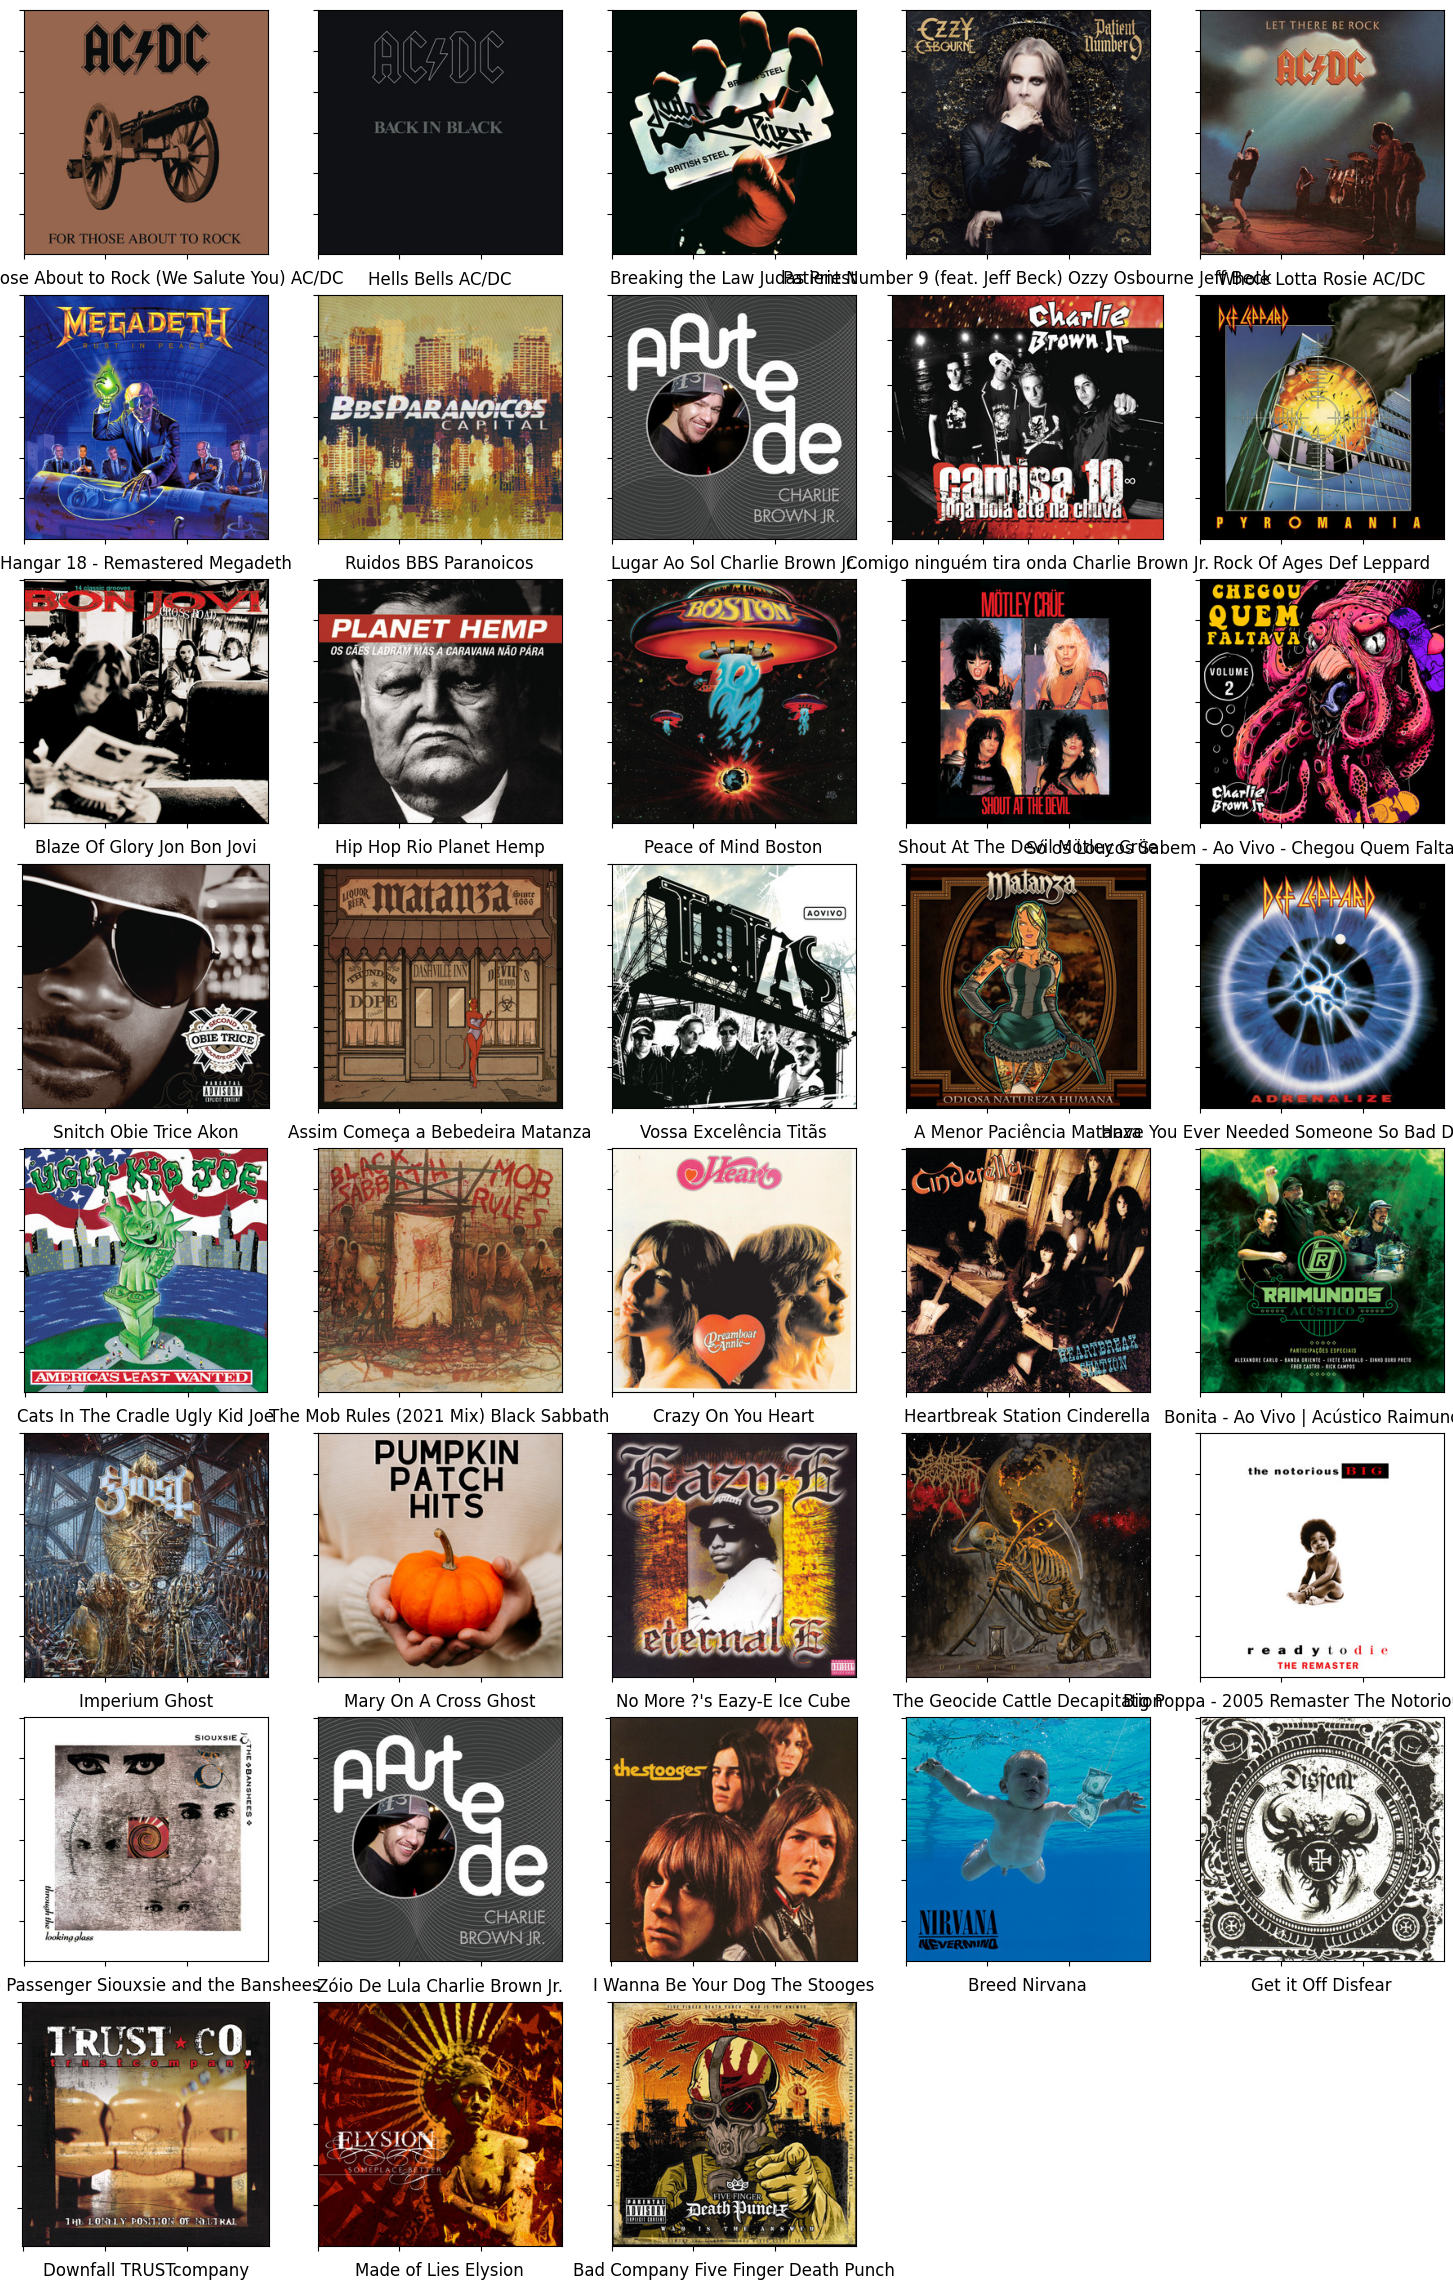

In [42]:
def visualize_songs_top40(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(f'{df['track_name'].values[i]} {df['artists'].values[i]}', fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

visualize_songs_top40(wicked_top_40)